# Quantum Elastic Wave Equation Solver
#### v0.3.0
*Authors: Malte Schade, Cyrill Bösch, Vaclav Hapla, Andreas Fichtner*

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

## 1. Importing Dependencies

In [1]:
from simulation.experiment import ForwardExperiment1D
from utility.distributions import (spike, ricker, gaussian, raised_cosine,
                                    sinc, homogeneous, exponential, polynomial)


## 2. Setting up Qiskit Runtime Service Account

In [2]:
# Set IBM Account
# from qiskit_ibm_runtime import QiskitRuntimeService
# user_token = ''
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token=user_token,
#     overwrite=True
#     )


In [3]:
# List all IBMQ Cloud Backends
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# service.backends()


## 3.1. Defining Simulation Parameters

In [4]:
# Set Experiment Parameters
nx = 7
parameters = {
    'dx': 1,                                        # Grid spacing
    'nx': nx,                                       # Number of grid points
    'dt': 0.0002,                                   # Time stepping
    'nt': 19,                                       # Number of time steps
    'order': 1,                                     # Finite-difference order
    'bcs': {'left': 'DBC', 'right': 'DBC'},         # Boundary conditions
    'mu': raised_cosine(3e10, nx+1, nx, 6, 1e10),   # Elastic modulus distribution
    'rho': raised_cosine(2e3, nx, nx-1, 6, 2e3),    # Density distribution
    'u': spike(1, nx, nx//2+1),                     # Initial positions
    'v': homogeneous(0, nx),                        # Initial velocities
    'backend': {
        'synthesis': 'MatrixExponential',           # Time Evolution Synthesis Method
        'batch_size': 100,                          # Circuit Batch Size
        'fitter': 'cvxpy_gaussian',                 # State Tomography fitter
        'backend': 'ibm_brisbane',                  # Cloud backend name
        'shots': 1000,                              # Number of circuit samples
        'optimization': 3,                          # Circuit optimization level
        'resilience': 1,                            # Circuit resilience level
        'seed': 0,                                  # Transpilation seed
        'local_transpilation': True,                # Local transpilation
        'method': 'statevector',                    # Classical simulation method
        'fake': None,                               # Fake backend model
        }
    }


## 3.2. Running Simulation Experiment

In [5]:
# Create new Experiment
# experiment = ForwardExperiment1D(verbose=2)
# experiment.add_solver('ode', **parameters)
# experiment.add_solver('exp', **parameters)
# experiment.add_solver('local', **parameters)
# experiment.add_solver('cloud', **parameters)


In [6]:
# Plot medium properties
# experiment.plot('medium', solvers=[0])

In [7]:
# Plot initial conditions
# experiment.plot('initial', solvers=[0])

In [8]:
# Run Experiment
# results = experiment.run()


## 4. Loading Simulation Experiment

In [9]:
# Load experiment from the cloud / local with experiment id
exp_id = '20231203T101131'
experiment = ForwardExperiment1D(experiment_id=exp_id, verbose=2, data_folder='examples')
results = experiment.load()


2023-12-24 11:57:39,873 - INFO - Loading experiment with time stamp: 20231203T101131.

2023-12-24 11:57:39,874 - INFO - Loading data for solver 1.
2023-12-24 11:57:39,875 - INFO - Loading data for solver 2.
2023-12-24 11:57:39,875 - INFO - Loading data for solver 3.
2023-12-24 11:57:39,876 - INFO - Data loaded.



## 5. Visualizing Results

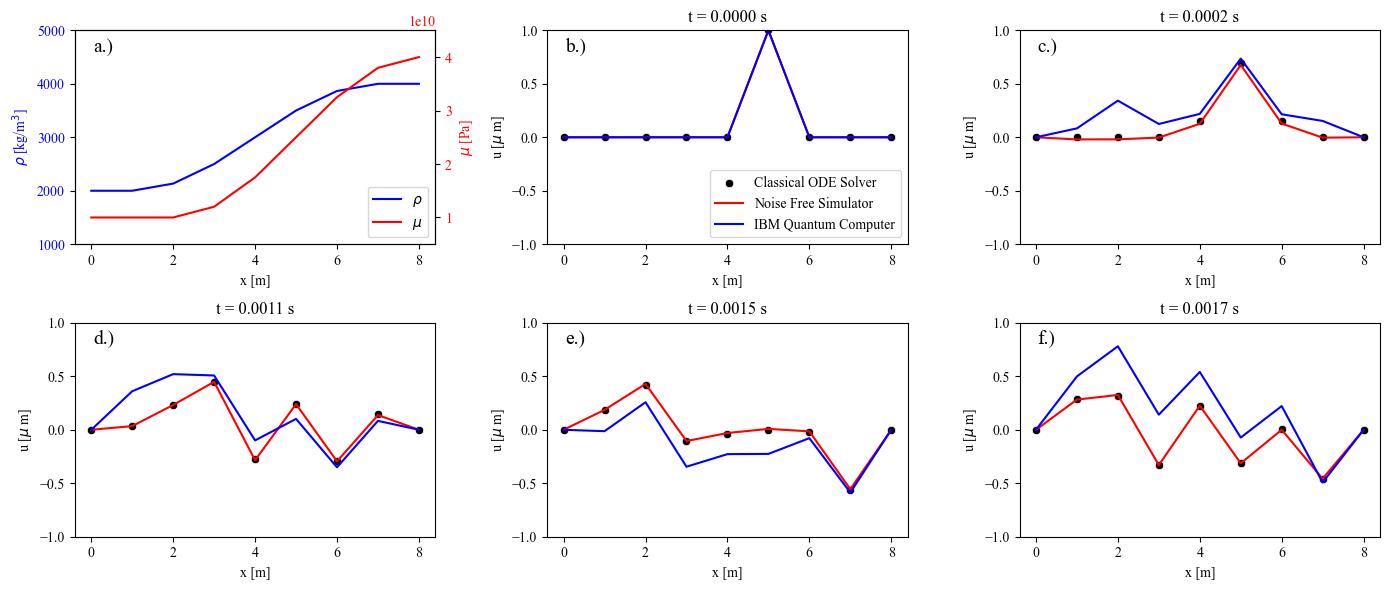

In [10]:
# Plot results for five time steps
experiment.plot('multi', solvers=[0,1,2], idx=[0,2,11,15,17])


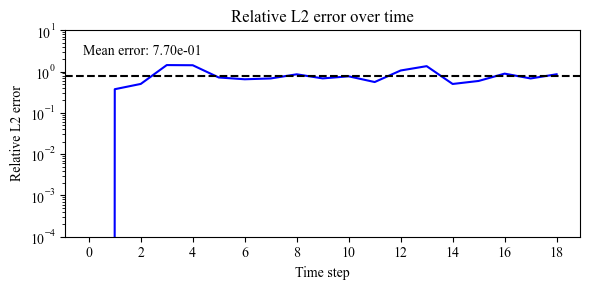

In [11]:
# Plot error between solvers
experiment.plot('error', solvers=[1,2])
